In [ ]:
import sys, subprocess
print(sys.executable)

subprocess.check_call([sys.executable, "-m", "pip", "install", "nbformat"])


c:\Users\BIT\Complete_ML\DNN_CIFAR10\.venv\Scripts\python.exe


0

In [ ]:
from pathlib import Path
import sys

nb_path = (Path.cwd().parent / "src" / "02_mlp_from_scratch.ipynb").resolve()

get_ipython().run_line_magic("run", f"-i {nb_path}")
print("Loaded definitions from:", nb_path)


Loaded definitions from: C:\Users\BIT\Complete_ML\DNN_CIFAR10\src\02_mlp_from_scratch.ipynb


In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display

from importlib import reload

DATA_DIR = Path.cwd().parent / "data" / "cifar10_torch_np"
SUFFIX = "gray" 
VALPCT = 10
npz_path = DATA_DIR / f"cifar10_{SUFFIX}_val{VALPCT}.npz"

data = np.load(npz_path)
Xtr, ytr, Xval, yval, Xte, yte = data["Xtr"], data["ytr"], data["Xval"], data["yval"], data["Xte"], data["yte"]
Xtr.shape, Xval.shape, Xte.shape


((45000, 1024), (5000, 1024), (10000, 1024))

In [13]:
def train(model, Xtr, ytr, Xval, yval, *, epochs=60, batch=128, lr=0.03, momentum=0.9, l2=1e-4, patience=10, rng=None):
    best = {"loss": np.inf, "state": None, "epoch": -1}
    wait = 0
    tr_hist, val_hist, acc_hist = [], [], []

    for ep in range(1, epochs+1):
        tot = 0.0
        for xb, yb in iterate_minibatches(Xtr, ytr, batch, True, rng):
            loss, grads = model.loss_and_grads(xb, yb, l2=l2)
            model.step(grads, lr=lr, momentum=momentum)
            tot += loss * xb.shape[0]
        tr_loss = tot / Xtr.shape[0]

        val_loss, _ = model.loss_and_grads(Xval, yval, l2=l2)
        val_acc = (model.forward(Xval)[0].argmax(1) == yval).mean()

        tr_hist.append(tr_loss); val_hist.append(val_loss); acc_hist.append(val_acc)
        print(f"ep {ep:03d} | tr {tr_loss:.4f} | val {val_loss:.4f} | acc {val_acc:.4f}")

        if val_loss < best["loss"] - 1e-4:
            best = {"loss": val_loss, "state": {k: v.copy() for k, v in model.params().items()}, "epoch": ep}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                for k, v in best["state"].items():
                    setattr(model, k, v)
                print(f"Early stop @ epoch {ep}, best epoch {best['epoch']}, val_loss={best['loss']:.4f}")
                break

    return {"tr_loss": tr_hist, "val_loss": val_hist, "val_acc": acc_hist}


In [ ]:
np.random.seed(3)
d_in = Xtr.shape[1]
h1 = 512 if d_in == 1024 else 1024
model = MLP(d_in=d_in, d_h1=h1, d_h2=256, d_out=10)

hist = train(model, Xtr, ytr, Xval, yval, epochs=60, batch=128, lr=0.03, momentum=0.9, l2=1e-4, patience=10)


ep 001 | tr 2.0830 | val 1.9654 | acc 0.3192
ep 002 | tr 1.9393 | val 1.9093 | acc 0.3484
ep 003 | tr 1.8756 | val 1.8999 | acc 0.3530
ep 004 | tr 1.8435 | val 1.8741 | acc 0.3726
ep 005 | tr 1.8013 | val 1.8299 | acc 0.3800
ep 006 | tr 1.7811 | val 1.8206 | acc 0.3816
ep 007 | tr 1.7499 | val 1.7770 | acc 0.4000
ep 008 | tr 1.7217 | val 1.7790 | acc 0.4006
ep 009 | tr 1.7009 | val 1.7510 | acc 0.4098
ep 010 | tr 1.6813 | val 1.7528 | acc 0.4148
ep 011 | tr 1.6598 | val 1.7618 | acc 0.4070
ep 012 | tr 1.6384 | val 1.7208 | acc 0.4328
ep 013 | tr 1.6159 | val 1.7214 | acc 0.4232
ep 014 | tr 1.6024 | val 1.7560 | acc 0.4124
ep 015 | tr 1.5794 | val 1.7523 | acc 0.4166
ep 016 | tr 1.5702 | val 1.7357 | acc 0.4256
ep 017 | tr 1.5493 | val 1.7354 | acc 0.4234
ep 018 | tr 1.5364 | val 1.7434 | acc 0.4228
ep 019 | tr 1.5219 | val 1.7686 | acc 0.4144
ep 020 | tr 1.5026 | val 1.7028 | acc 0.4280
ep 021 | tr 1.4804 | val 1.7533 | acc 0.4160
ep 022 | tr 1.4733 | val 1.7253 | acc 0.4292
ep 023 | t

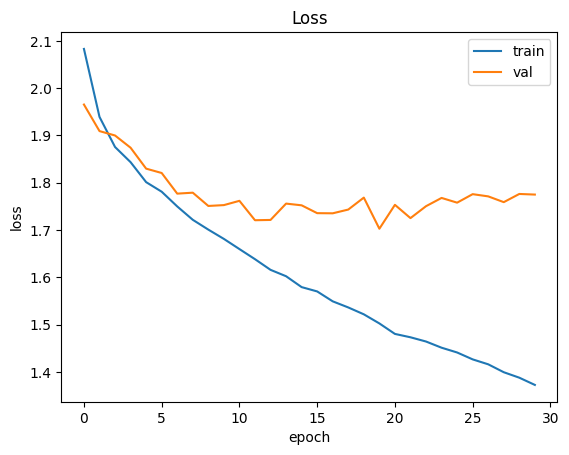

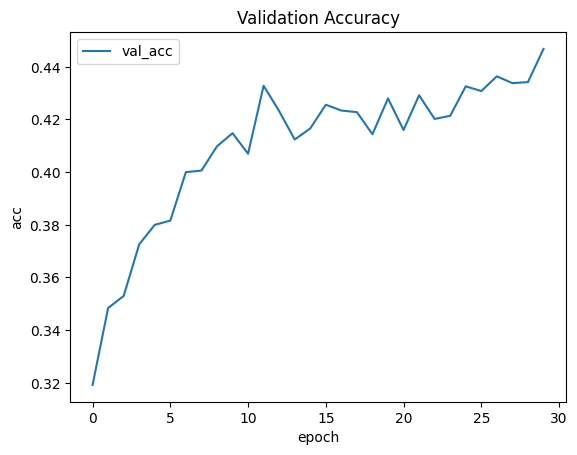

In [15]:
plt.figure(); plt.plot(hist["tr_loss"], label="train"); plt.plot(hist["val_loss"], label="val"); plt.legend(); plt.title("Loss"); plt.xlabel("epoch"); plt.ylabel("loss"); plt.show()
plt.figure(); plt.plot(hist["val_acc"], label="val_acc"); plt.legend(); plt.title("Validation Accuracy"); plt.xlabel("epoch"); plt.ylabel("acc"); plt.show()


Test acc: 0.4327
              precision    recall  f1-score   support

    airplane       0.55      0.32      0.41      1000
  automobile       0.56      0.55      0.55      1000
        bird       0.33      0.33      0.33      1000
         cat       0.32      0.22      0.26      1000
        deer       0.32      0.39      0.35      1000
         dog       0.43      0.31      0.36      1000
        frog       0.38      0.60      0.46      1000
       horse       0.48      0.54      0.51      1000
        ship       0.48      0.58      0.53      1000
       truck       0.53      0.48      0.51      1000

    accuracy                           0.43     10000
   macro avg       0.44      0.43      0.43     10000
weighted avg       0.44      0.43      0.43     10000



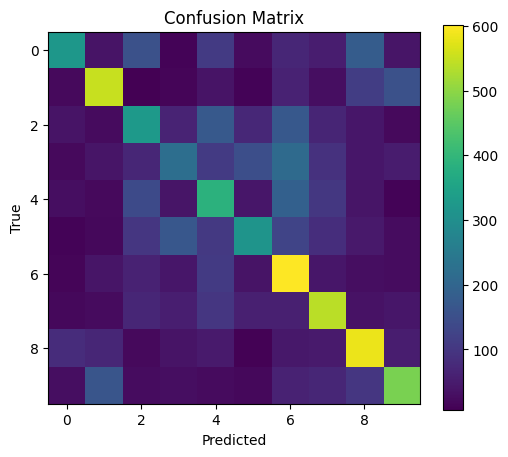

In [16]:
probs, _ = model.forward(Xte)
yhat = probs.argmax(1)
acc = (yhat == yte).mean()
print(f"Test acc: {acc:.4f}")

print(classification_report(yte, yhat, target_names=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']))

cm = confusion_matrix(yte, yhat)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar(); plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()
